In [7]:
import os,time
import scipy.io
import scipy.stats
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from IPython.display import clear_output

print(tf.__version__)

gpus = tf.config.list_physical_devices(device_type='GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
except:
    print('Error!')
    pass

2.4.0-dev20200711
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
dp = 'F:\\Data\\phm-ieee-2012-data-challenge-dataset-master\\mat'
bearing_files = [os.path.join(dp,file) for file in os.listdir(dp)]
bearing_files

['F:\\Data\\phm-ieee-2012-data-challenge-dataset-master\\mat\\Bearing1_1.mat',
 'F:\\Data\\phm-ieee-2012-data-challenge-dataset-master\\mat\\Bearing1_2.mat',
 'F:\\Data\\phm-ieee-2012-data-challenge-dataset-master\\mat\\Bearing1_3.mat',
 'F:\\Data\\phm-ieee-2012-data-challenge-dataset-master\\mat\\Bearing1_4.mat',
 'F:\\Data\\phm-ieee-2012-data-challenge-dataset-master\\mat\\Bearing1_5.mat',
 'F:\\Data\\phm-ieee-2012-data-challenge-dataset-master\\mat\\Bearing1_6.mat',
 'F:\\Data\\phm-ieee-2012-data-challenge-dataset-master\\mat\\Bearing1_7.mat',
 'F:\\Data\\phm-ieee-2012-data-challenge-dataset-master\\mat\\Bearing2_1.mat',
 'F:\\Data\\phm-ieee-2012-data-challenge-dataset-master\\mat\\Bearing2_2.mat',
 'F:\\Data\\phm-ieee-2012-data-challenge-dataset-master\\mat\\Bearing2_3.mat',
 'F:\\Data\\phm-ieee-2012-data-challenge-dataset-master\\mat\\Bearing2_4.mat',
 'F:\\Data\\phm-ieee-2012-data-challenge-dataset-master\\mat\\Bearing2_5.mat',
 'F:\\Data\\phm-ieee-2012-data-challenge-dataset-mas

In [3]:
def load_mat(f):
    '''加载处理好的mat文件，返回其中的水平、垂直震动信号数据 '''
    bearing_vibration_signal = scipy.io.loadmat(f)
    h = bearing_vibration_signal['h'][0]
    v = bearing_vibration_signal['v'][0]
    return h,v

h,v = load_mat('../XJTU-mat/Bearing1_1.mat')
h.shape,v.shape

((314880,), (314880,))

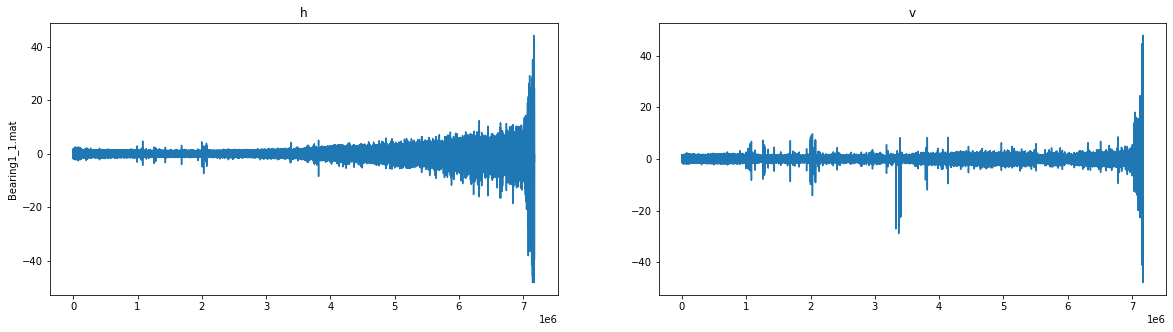

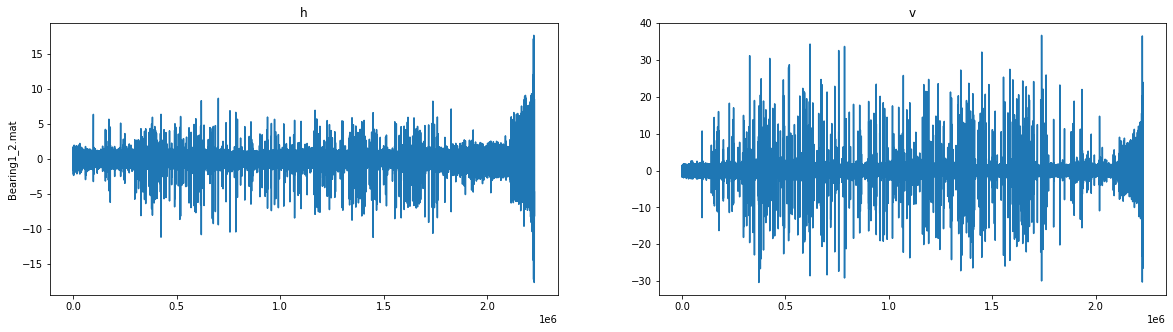

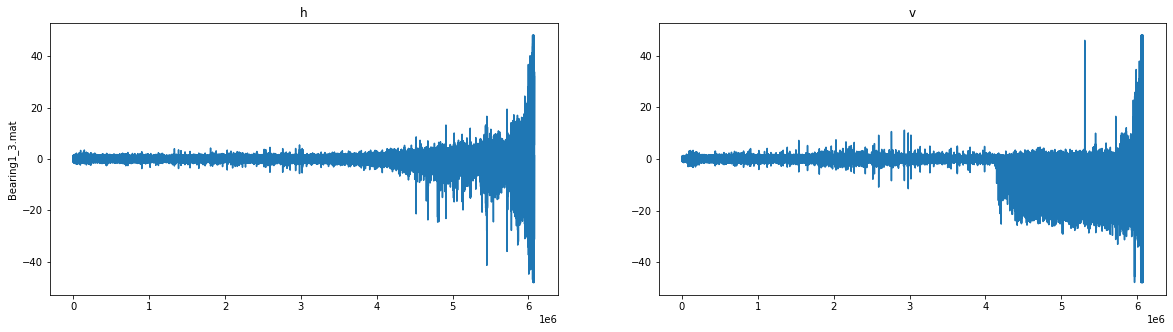

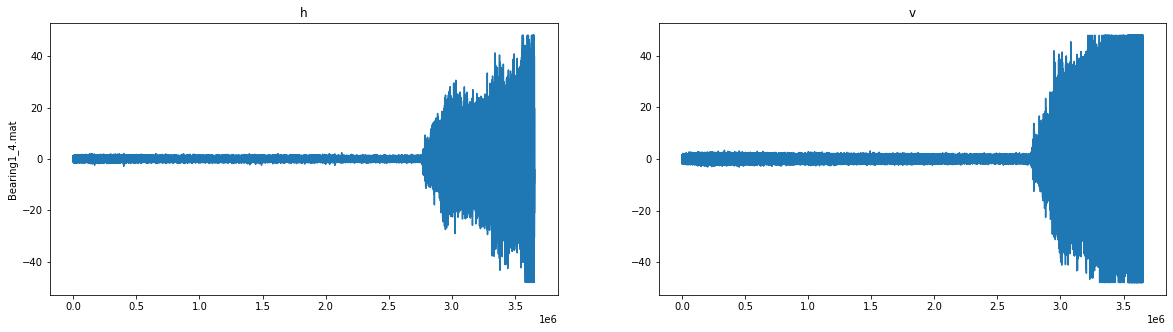

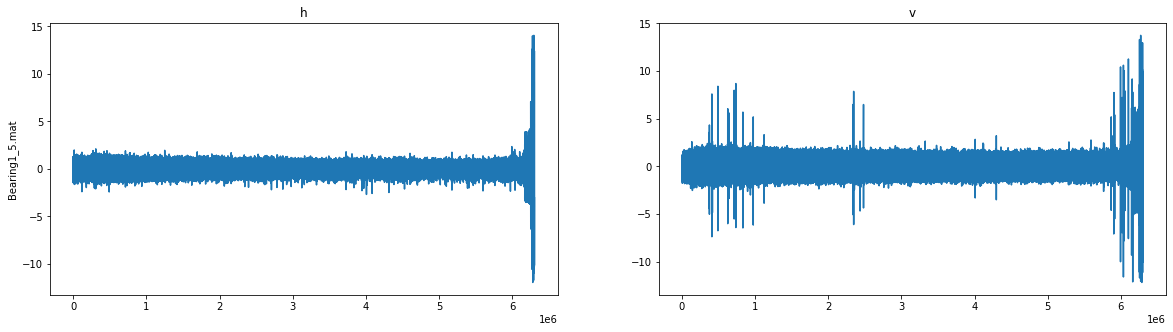

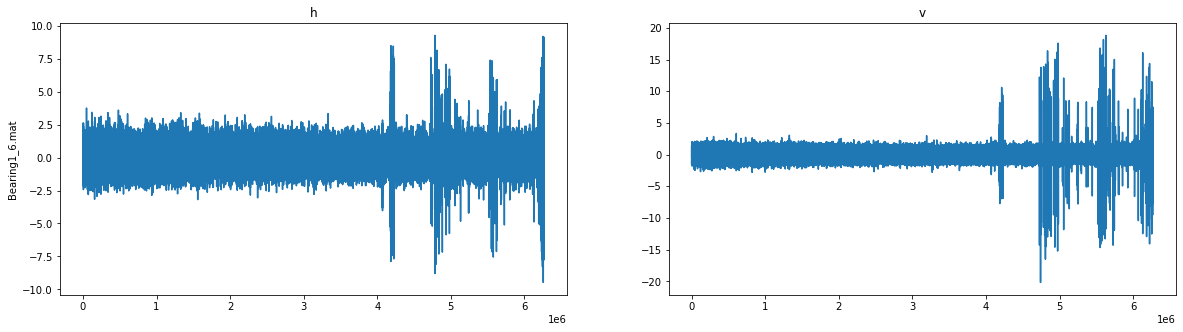

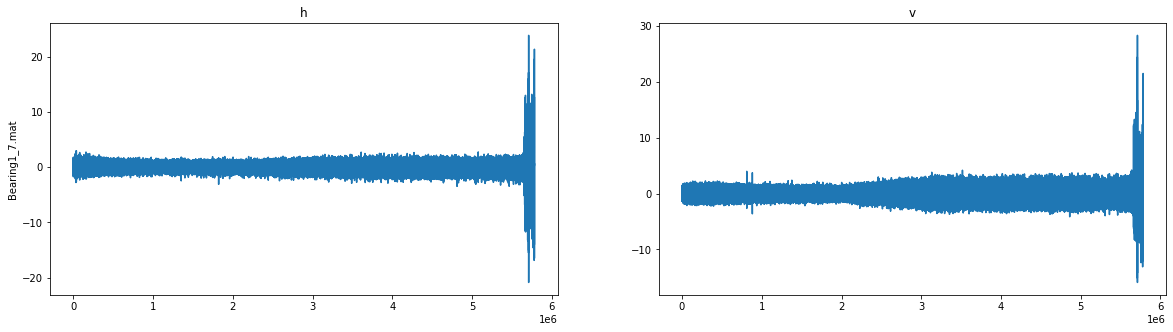

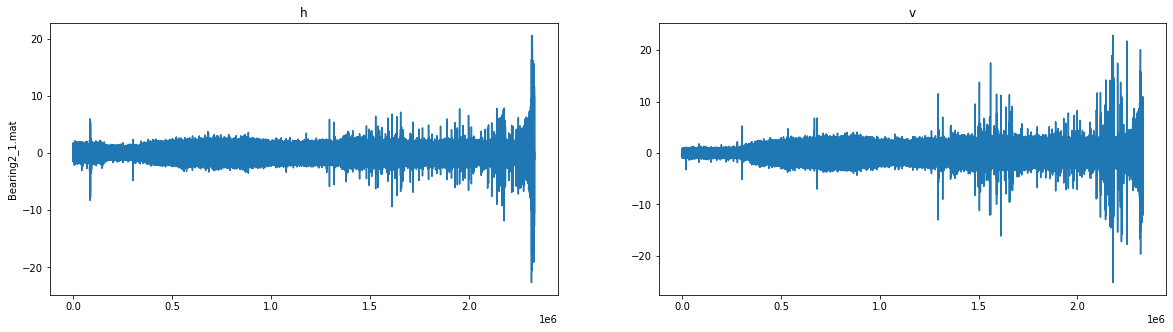

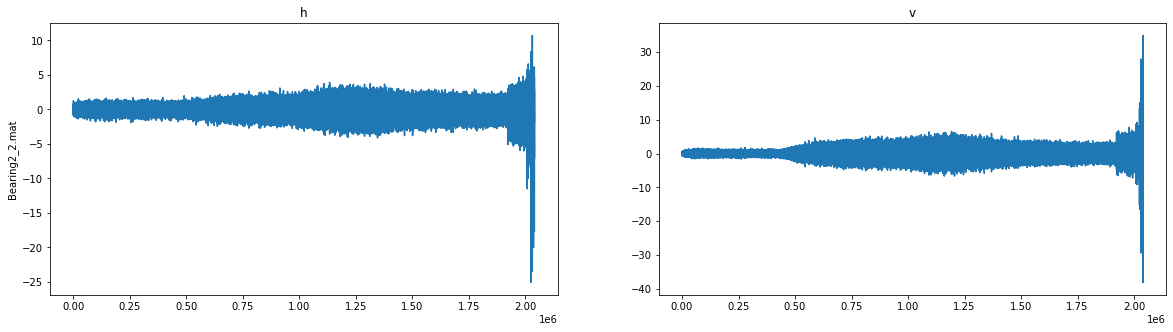

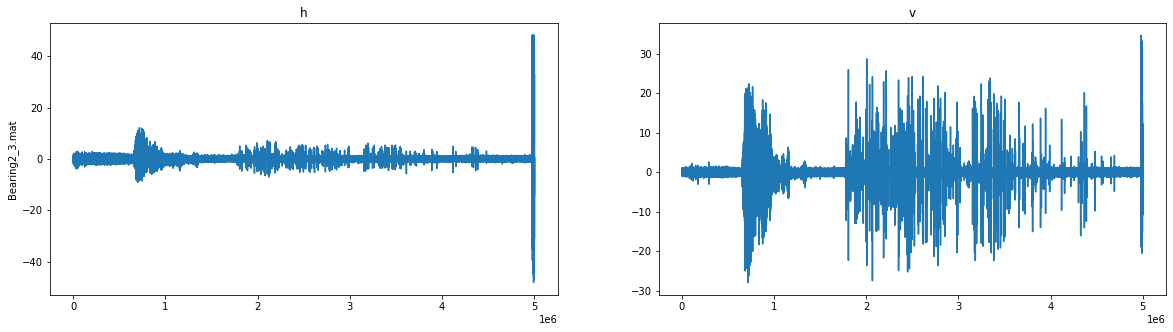

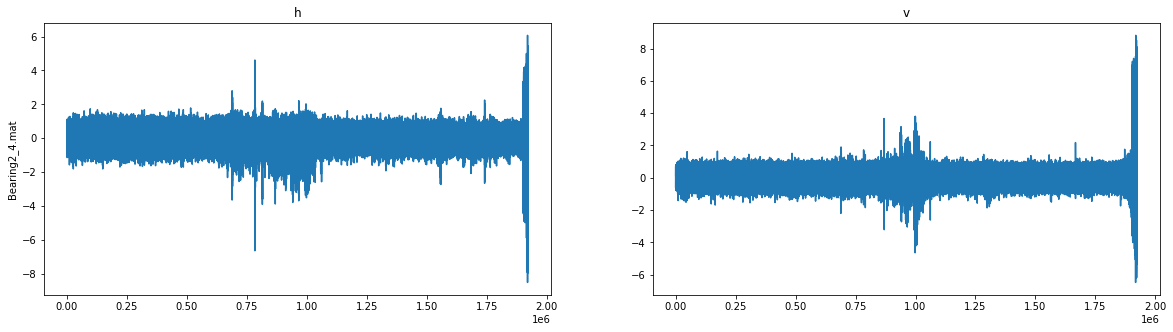

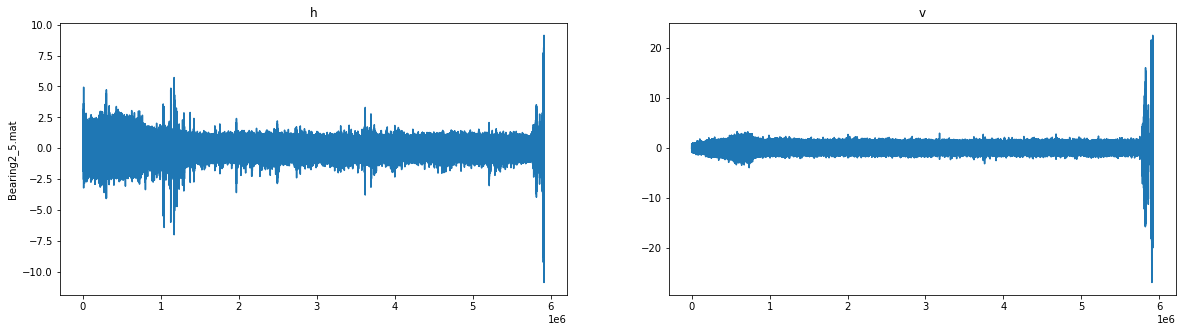

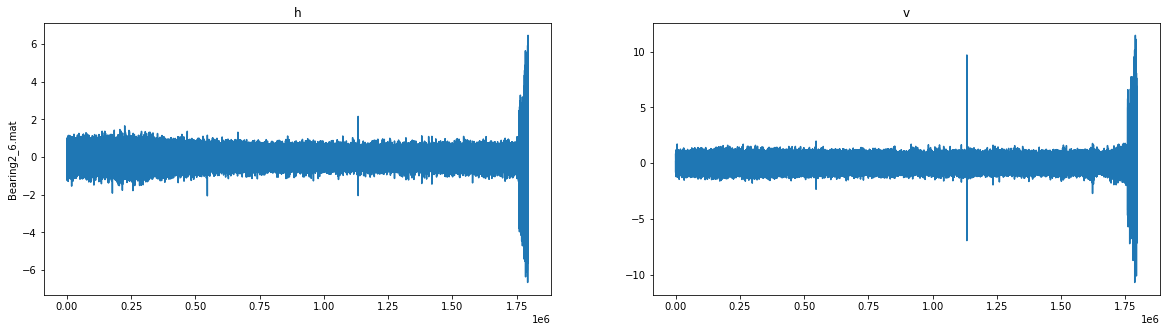

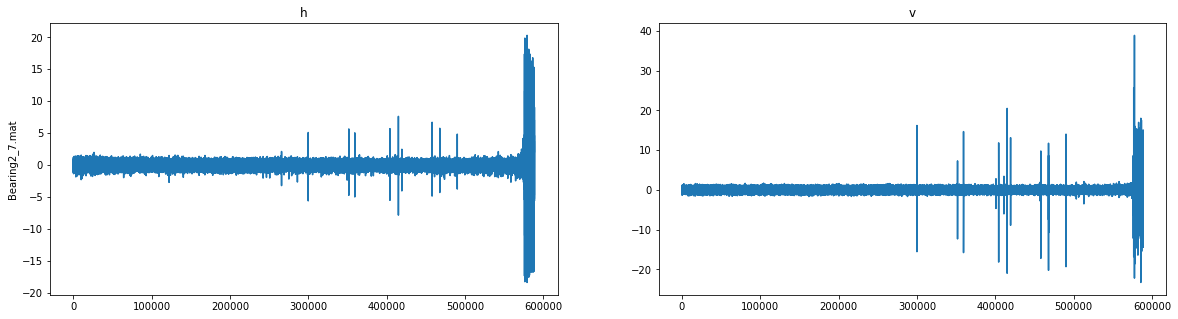

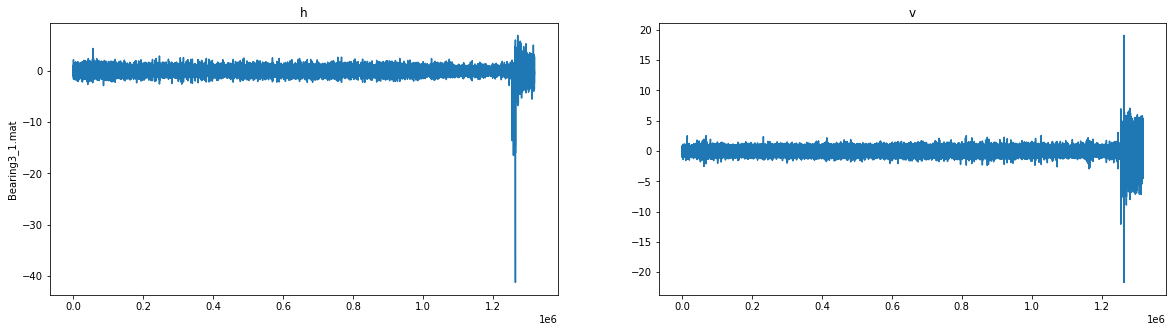

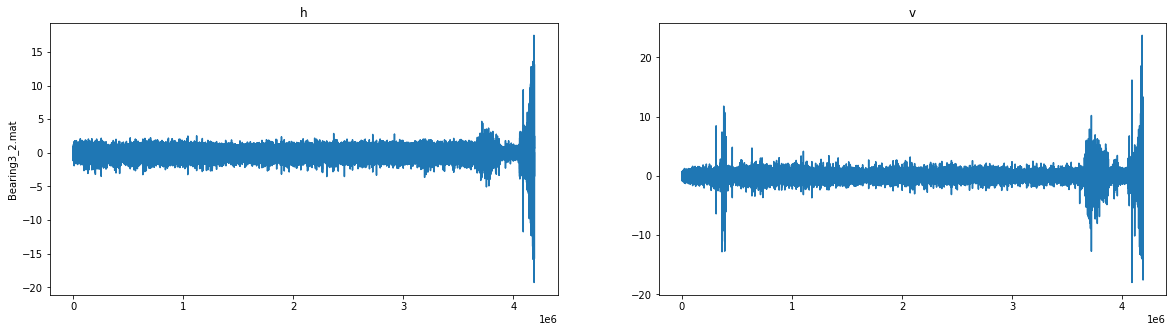

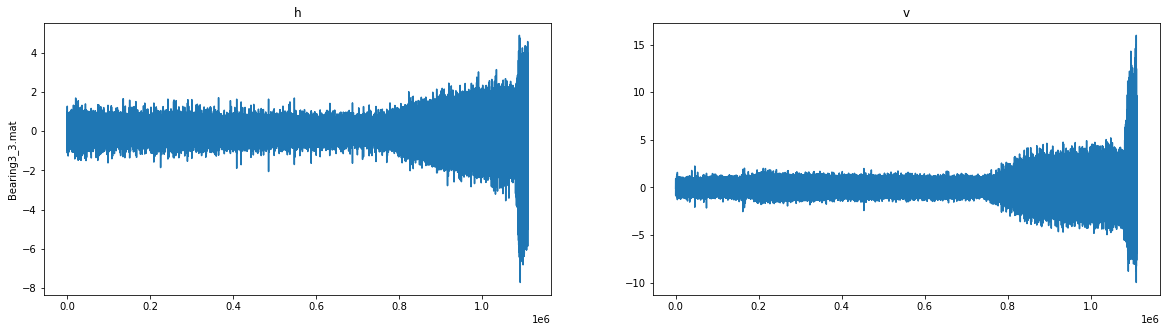

In [4]:
for f in bearing_files:
    h,v = load_mat(f)
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.plot(h)
    plt.ylabel(f.split('\\')[-1])
    plt.title('h')

    plt.subplot(122)
    plt.plot(v)
    plt.title('v')
    plt.show()

(2803, 2560)


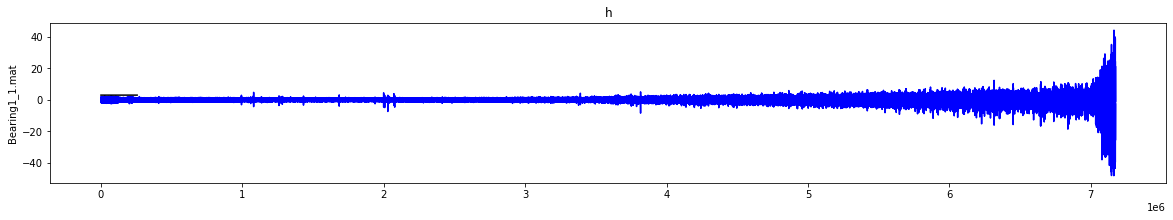

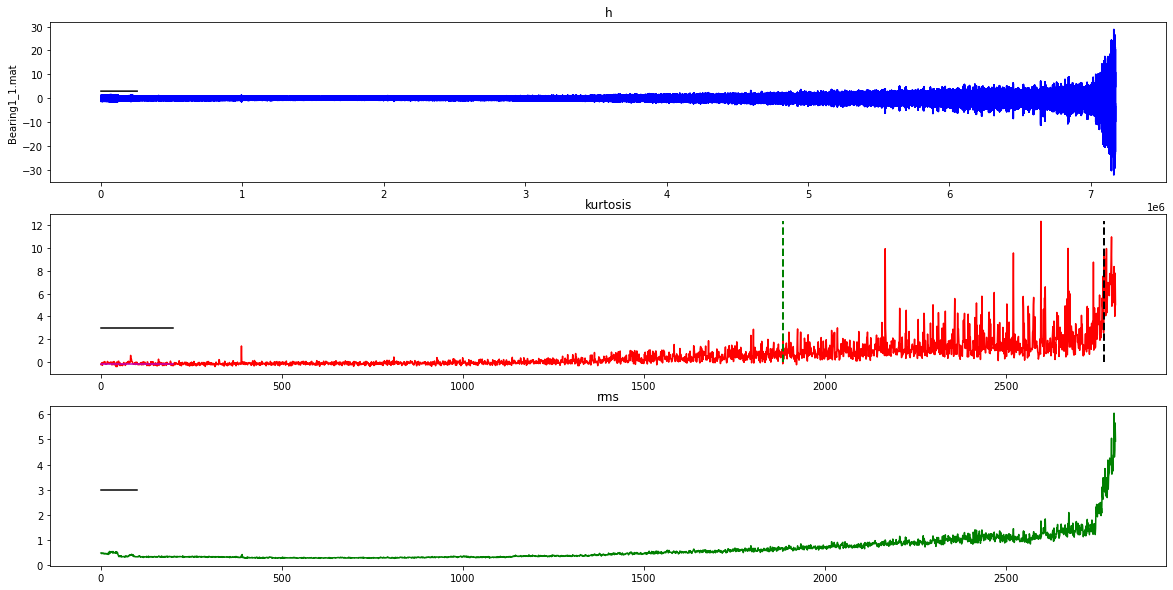

(871, 2560)


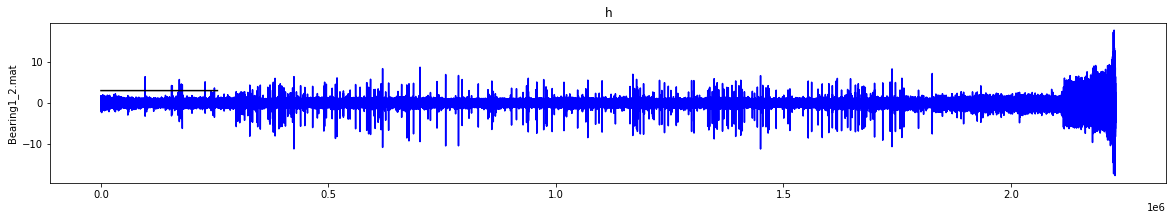

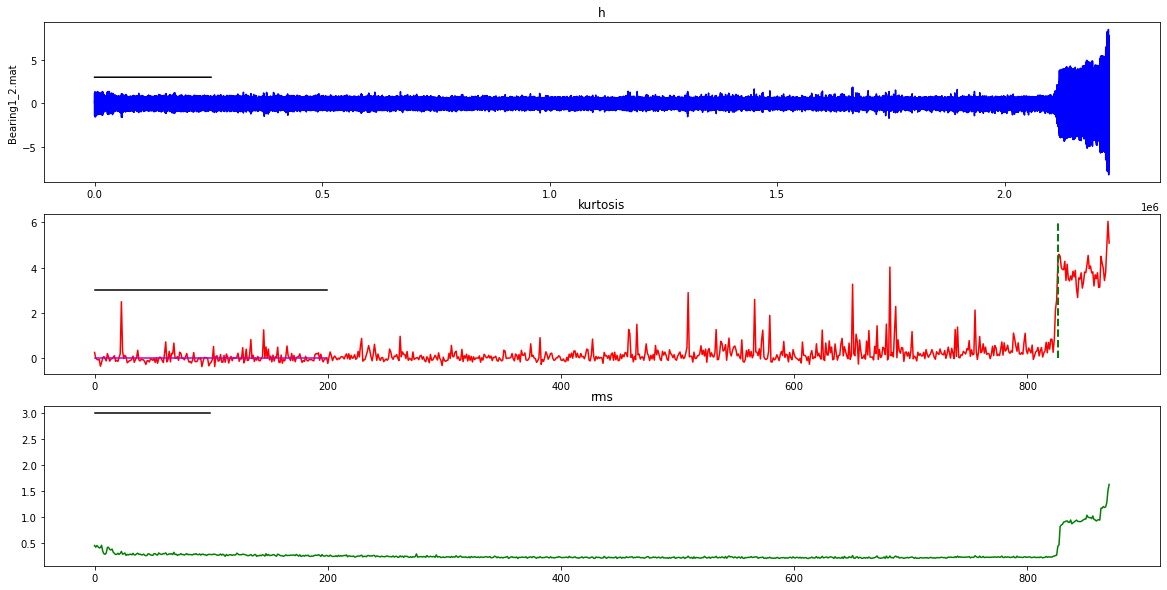

(2375, 2560)


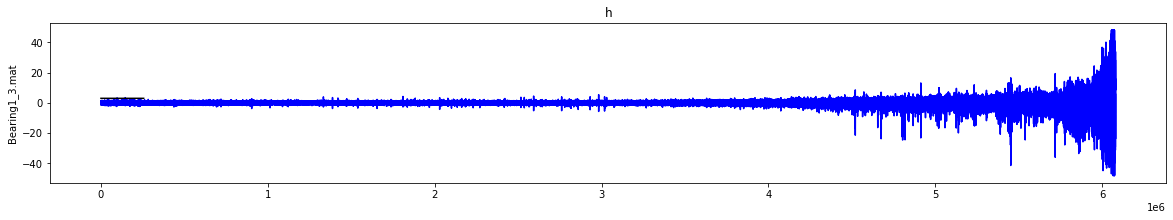

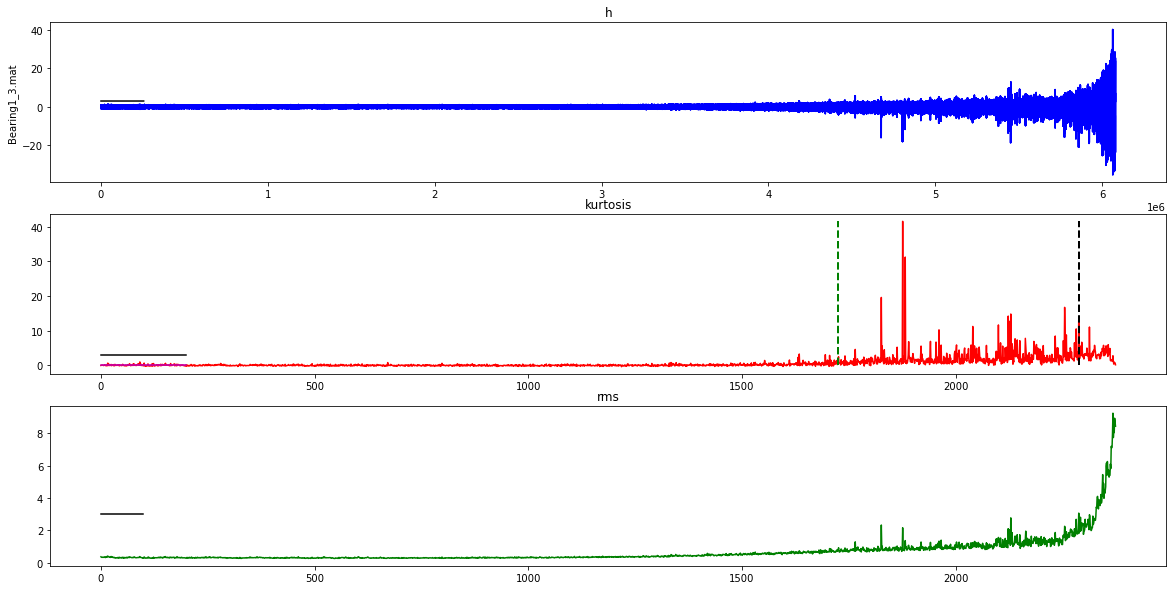

(1428, 2560)


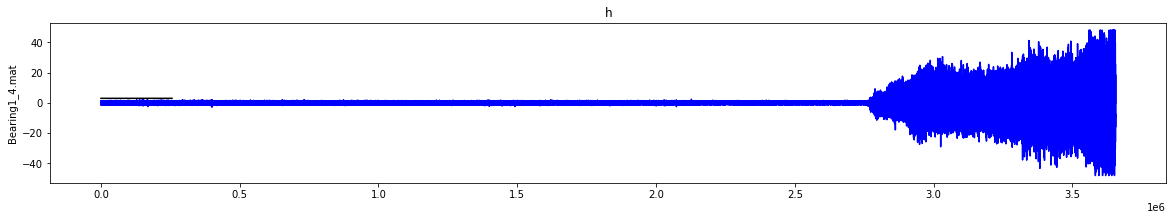

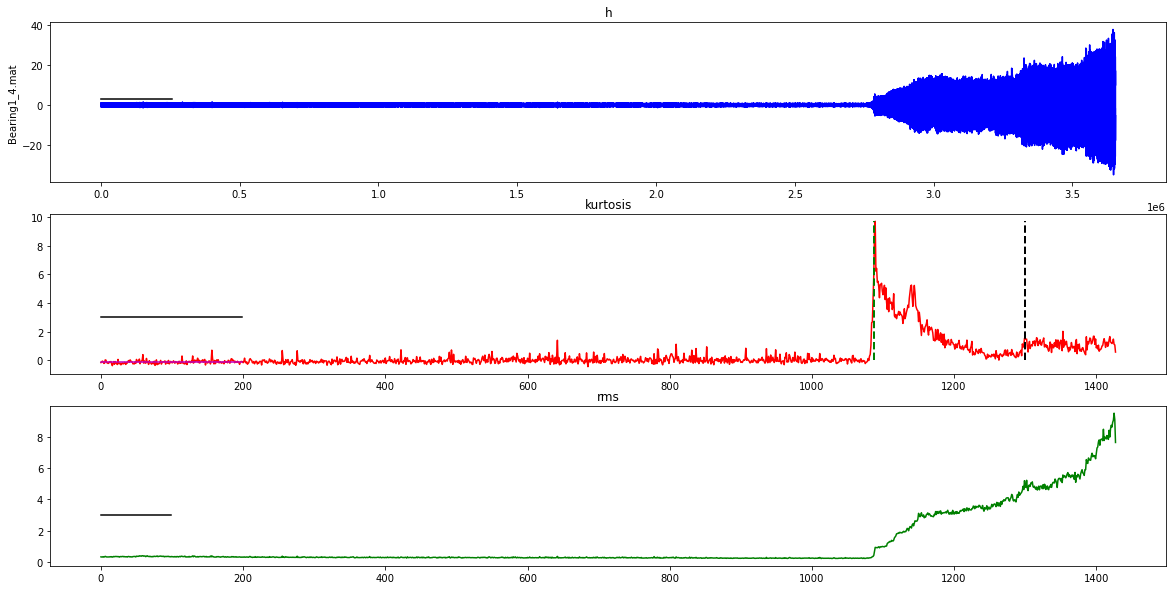

In [30]:
def clip(x):
    row_shape = x.shape
    if len(row_shape) < 2:
        x = x.reshape(-1,2560)
    for i in range(len(x)):
        d = x[i]
        sort_d = np.sort(d)
        n = int(2560*0.005)
        mi = sort_d[n]
        ma = sort_d[-n]
        d = np.clip(d,mi,ma)

#         filter_ = [0.1,0.2,0.4,0.2,0.1]
#         d = np.convolve(a=d, v=filter_, mode='same')
        x[i] = d
    if len(row_shape) < 2:
        x = x.reshape(-1)
    return x

def get_kurtosis(x):
    x = x.reshape(-1,2560)
    kurtosis = np.array( [scipy.stats.kurtosis(i) for i in x] )
#     skew = np.array( [scipy.stats.skew(i) for i in x] )
    rms = np.array( [np.mean(i**2)**0.5 for i in x] )

    return kurtosis, rms

def get_FPT(x):
    kurtosis, rms = get_kurtosis(x)
    k = 200
#     sample_kurt = np.sort(kurtosis[:k])[1:-1]
#     sample_rms = np.sort(rms[:k])[1:-1]
    sample_kurt = np.sort(kurtosis[:k])
    sample_rms = np.sort(rms[:k])
    
    mi_kurt = np.mean( sample_kurt ) - 3*np.std( sample_kurt )
    ma_kurt = np.mean( sample_kurt ) + 3*np.std( sample_kurt )
    k = 1
    mi_rms = np.mean( sample_rms ) - k*np.std( sample_rms )
    ma_rms = np.mean( sample_rms ) + k*np.std( sample_rms )
    length = 5
    FPT = 0
    for i in range(len(kurtosis)): # i= 0/1 
        if (kurtosis[i]<mi_kurt or kurtosis[i]>ma_kurt) and (rms[i]<mi_rms or rms[i]>ma_rms) and kurtosis[i]>2:
            for j in range(i+1,i+length+1): # j= 1/2 >>> 20/21 
                if j>=len(kurtosis): break
                if (kurtosis[j]<mi_kurt or kurtosis[j]>ma_kurt) and (rms[j]<mi_rms or rms[j]>ma_rms) and kurtosis[i]>2:
                    continue
                else:
                    break
            if j==i+length:
                FPT = i
                break
            i = j + 1 # i= 21/22
    return FPT

def get_LPT(x):
    x2 = x.reshape(-1,2560)
    print(x2.shape)
    
    length = 5
    LPT = 0
    for i in range(len(x2)): # i= 0/1 
#         print(i,x2[i].shape,np.max(x2[i]),np.min(x2[i]),  np.max(x2[i])>20 , np.min(x2[i])<-20)
        if np.max(x2[i])>20 or np.min(x2[i])<-20:
#                 print(111111111111111111111111111111111)
            for j in range(i+1,i+length+1): # j= 1/2 >>> 20/21 
                if j>=len(kurtosis): break
                if np.max(x2[i])>20 or np.min(x2[i])<-20:
                    continue
                else:
                    break
            if j==i+length:
                LPT = i
                break
            i = j + 1 # i= 21/22
    return LPT



for f in bearing_files[:]:
    if '1_1' in f or  '1_3' in f or  '1_4' in f or  '1_2' in f :
        
        h,v = load_mat(f)
        plt.figure(figsize=(20,10))
        plt.subplot(311)
        plt.plot(h,'b')
        plt.plot(np.ones(shape=(100*2560,))*3,'k')
        plt.ylabel(f.split('\\')[-1])
        plt.title('h')

        h = clip(h)
    #     h = sample(h)
        h = np.convolve(a=h,v=[0.2,0.6,0.2],mode='same')
        kurtosis, rms   = get_kurtosis(h)
        plt.figure(figsize=(20,10))
        plt.subplot(311)
        plt.plot(h,'b')
        plt.plot(np.ones(shape=(100*2560,))*3,'k')
        plt.ylabel(f.split('\\')[-1])
        plt.title('h')

        plt.subplot(312)
        plt.plot(kurtosis,'r')
        k=200
        plt.plot(np.ones(shape=(k,))*3,'k')
        plt.plot(np.ones(shape=(k,))*np.mean(kurtosis[:k]),'m')

        FPT = get_FPT(h)
        plt.plot([FPT,FPT],[0,np.max(kurtosis)],'g--',lw=2)
        
        LPT = get_LPT(h)
        if LPT>0:
            plt.plot([LPT,LPT],[0,np.max(kurtosis)],'k--',lw=2)

        plt.title('kurtosis')

        plt.subplot(313)
        plt.plot(rms,'g')
        plt.plot(np.ones(shape=(100,))*3,'k')
        plt.title('rms')
        plt.show()

In [100]:
np.mean( kurtosis[:])

0.3892533978514837

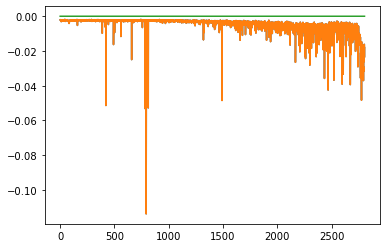

In [66]:
plt.plot(kurtosis- K)
plt.plot(kurtosis-rms)
plt.plot(K-rms)

In [5]:
h.reshape(-1,2560).shape

(434, 2560)

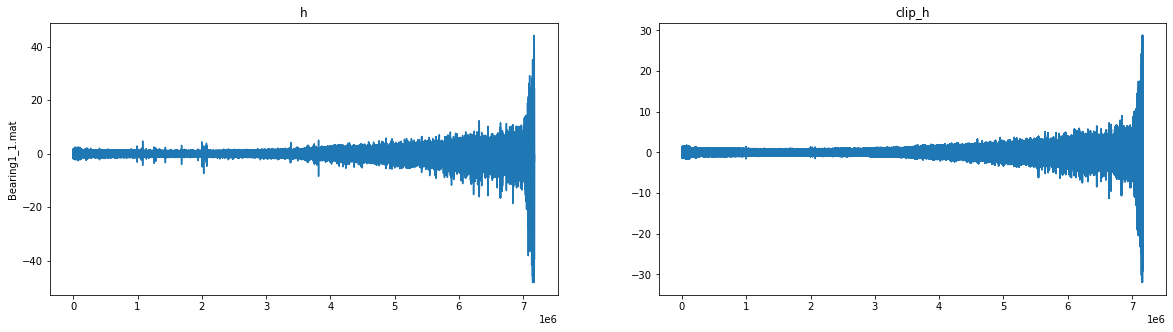

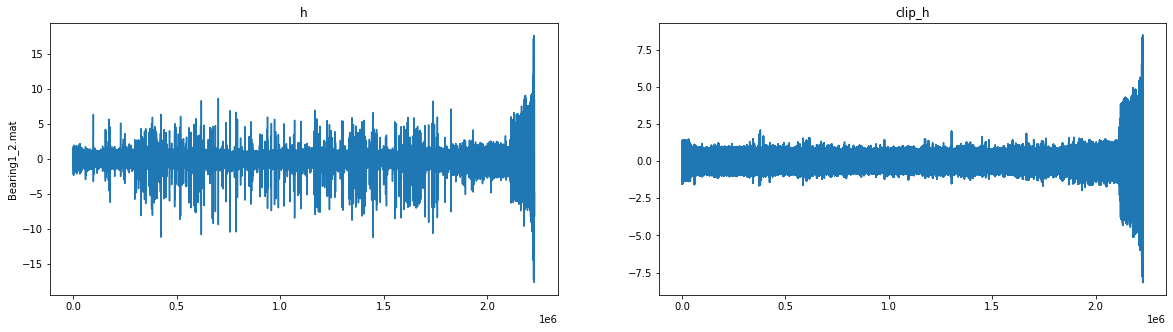

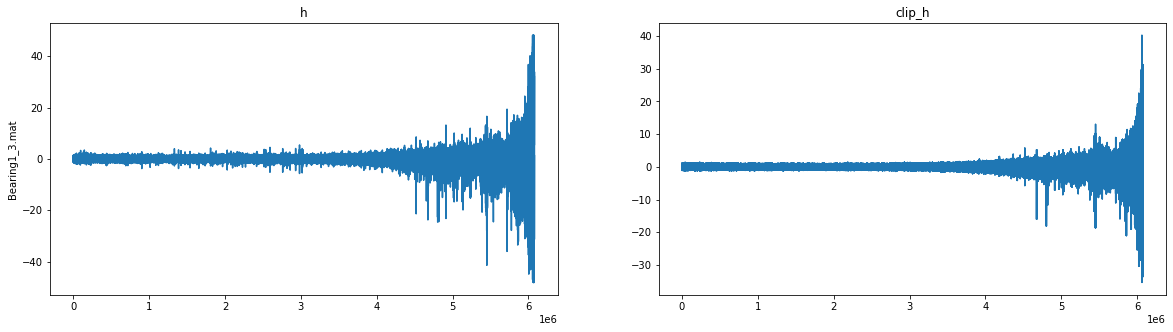

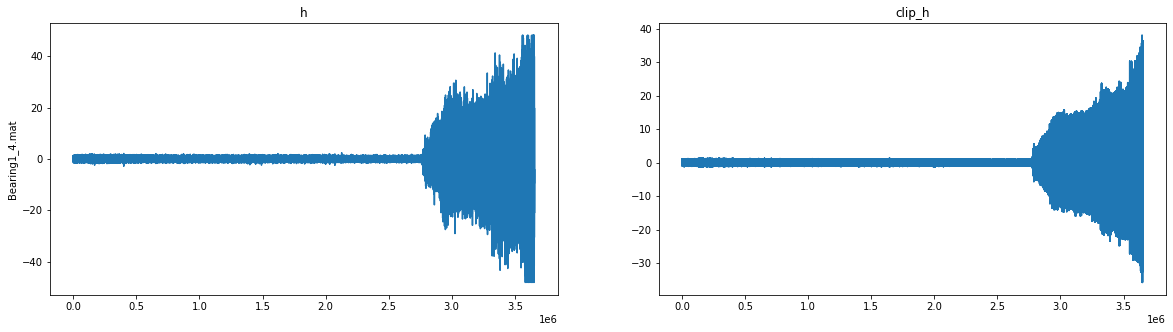

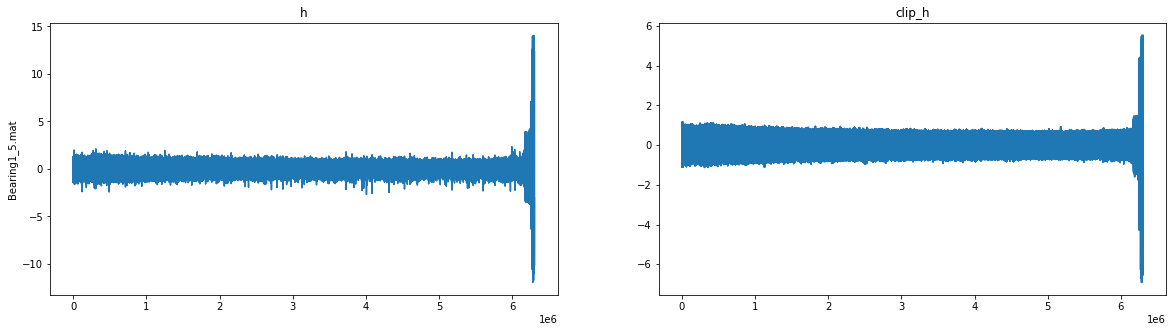

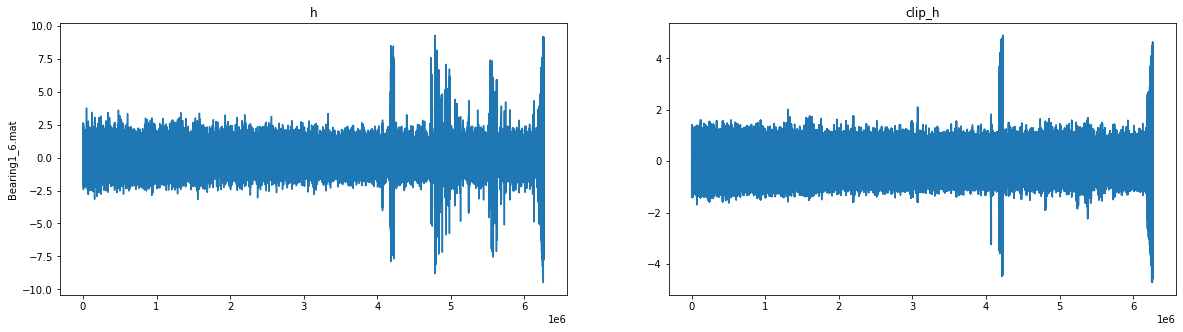

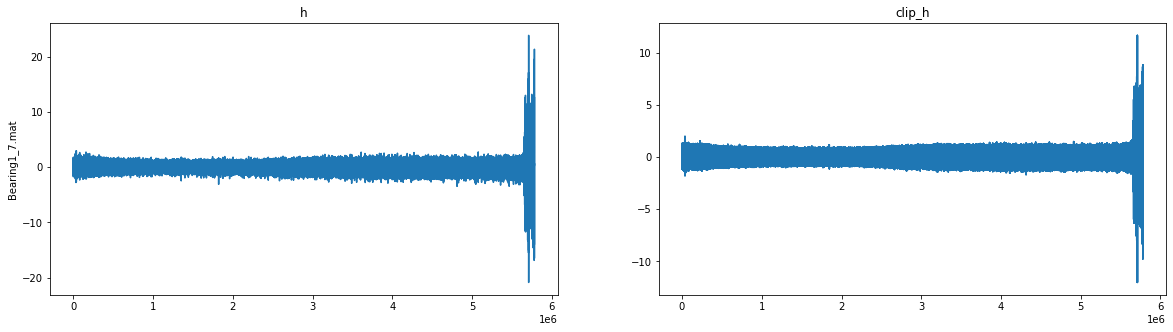

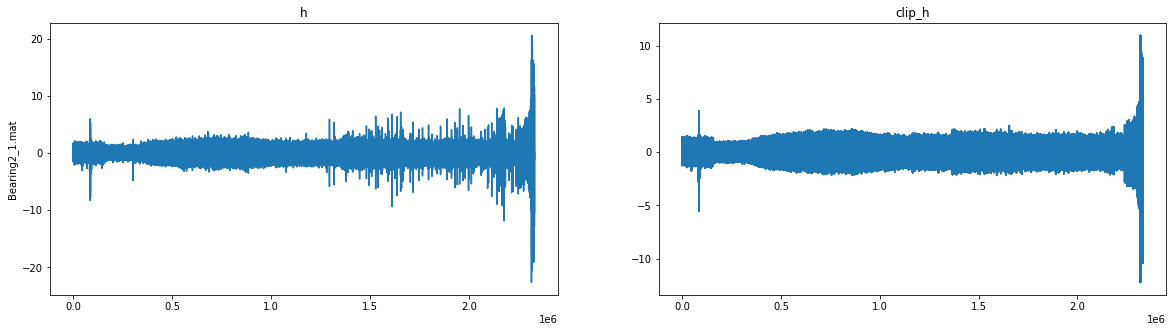

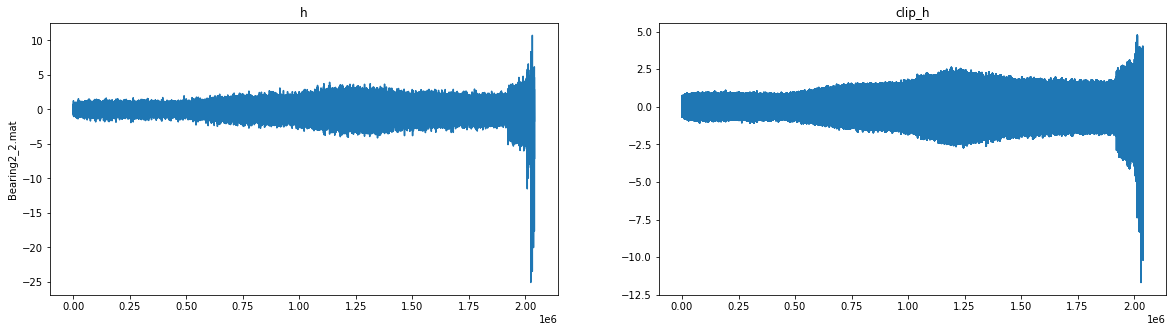

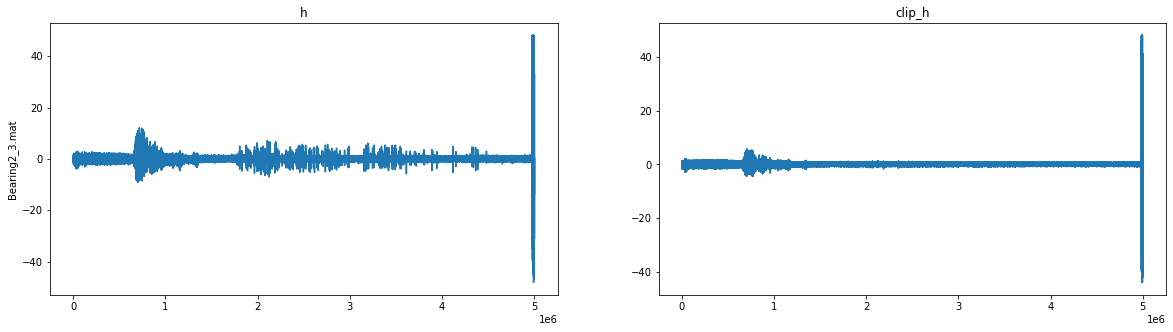

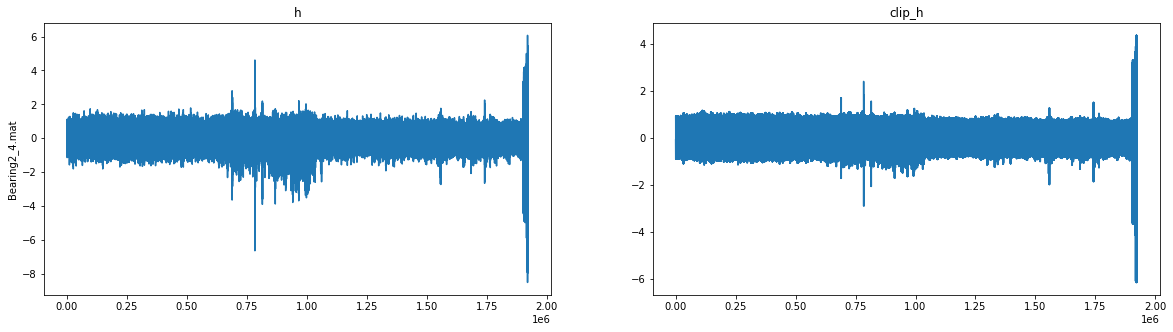

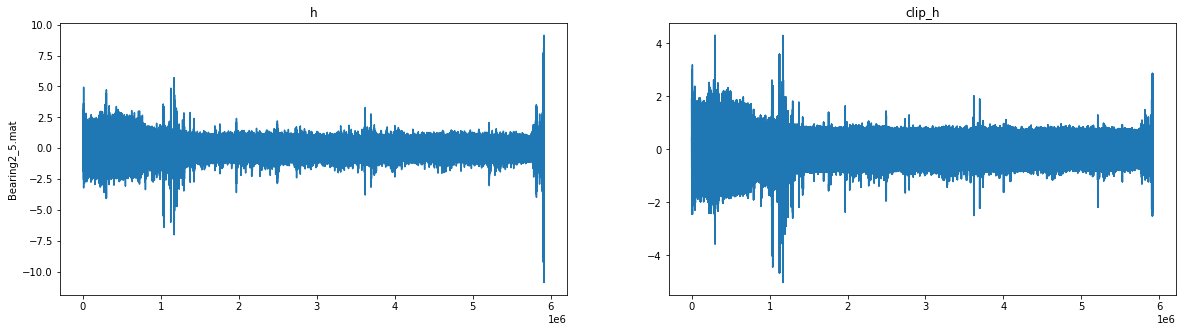

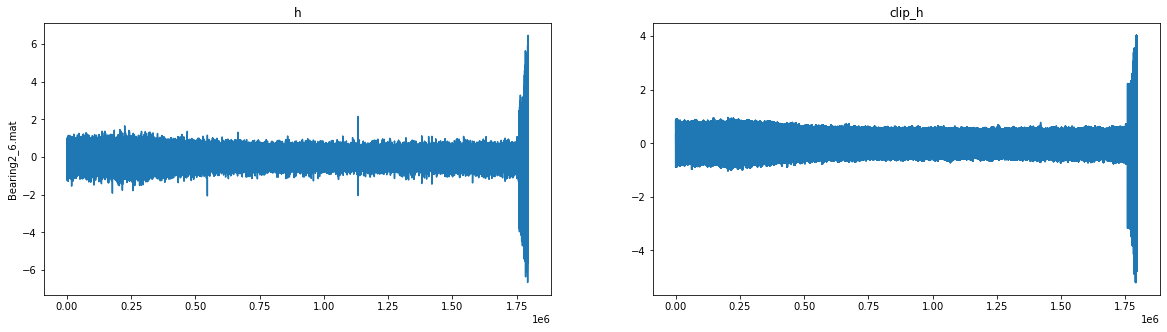

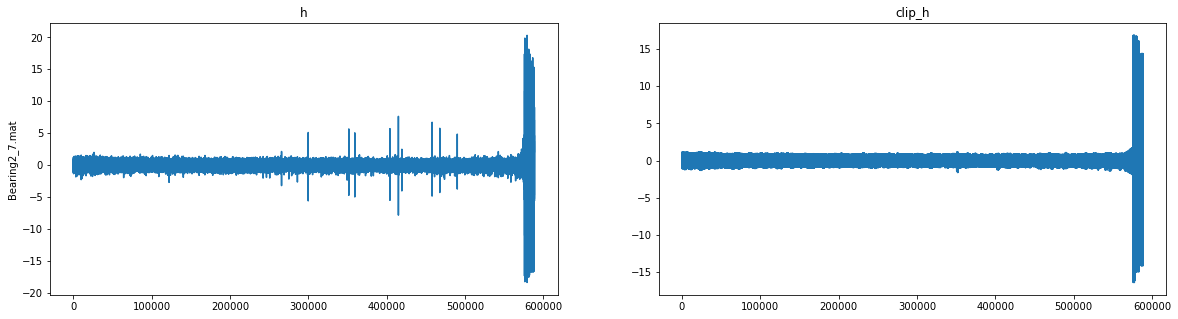

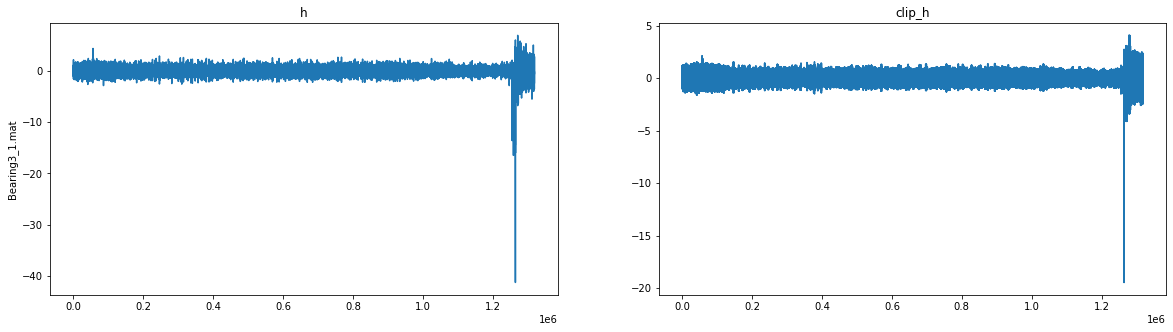

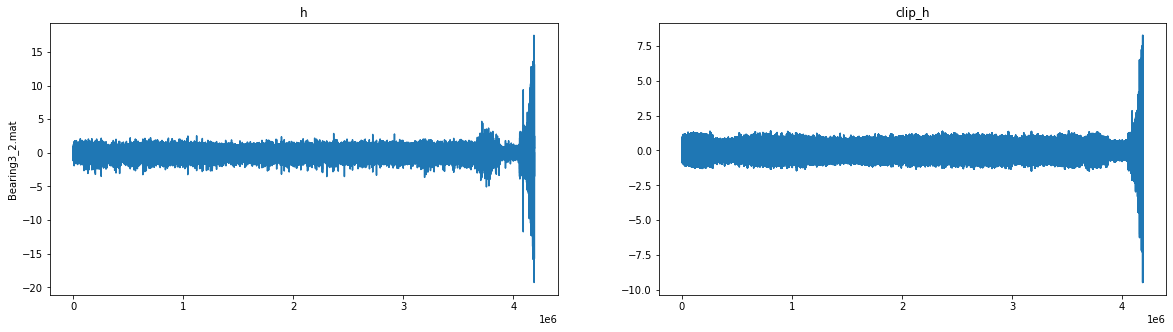

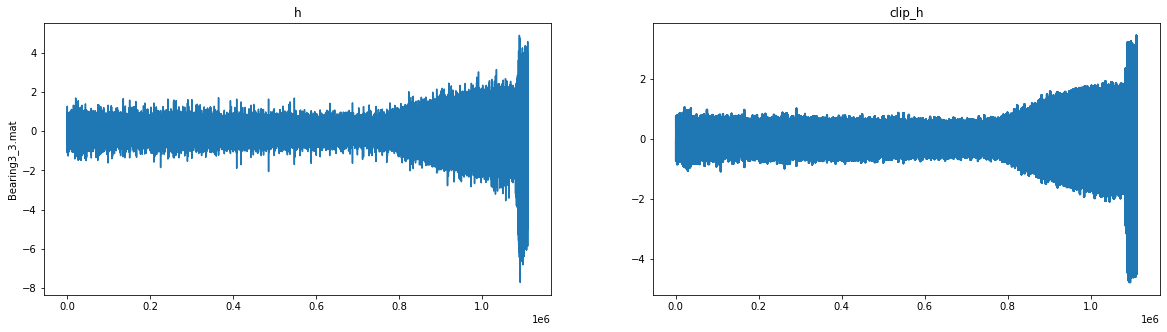

In [38]:
for f in bearing_files:
    h,v = load_mat(f)
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.plot(h)
    plt.ylabel(f.split('\\')[-1])
    plt.title('h')

    plt.subplot(122)
    plt.plot(clip(h))
    plt.title('clip_h')
    plt.show()

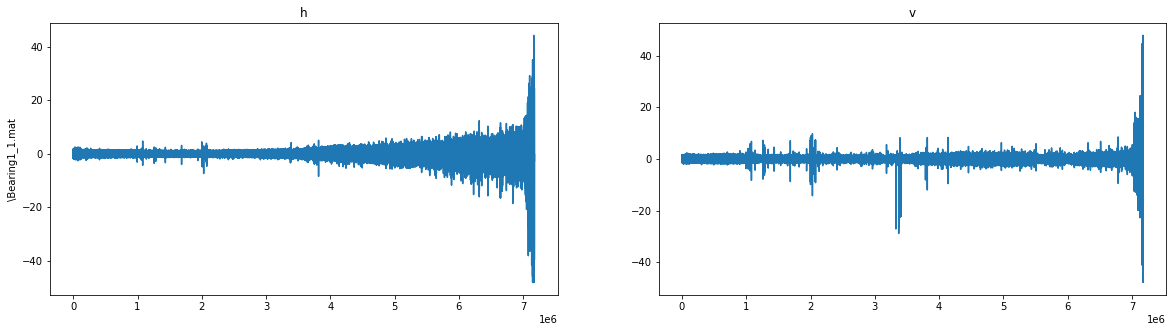

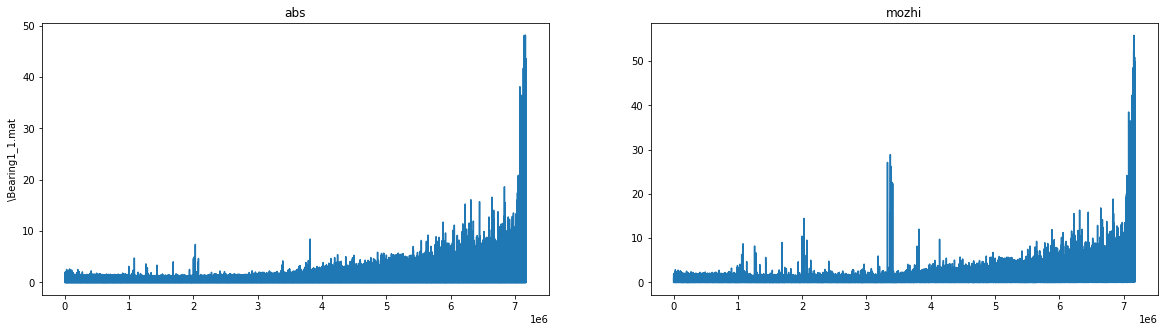

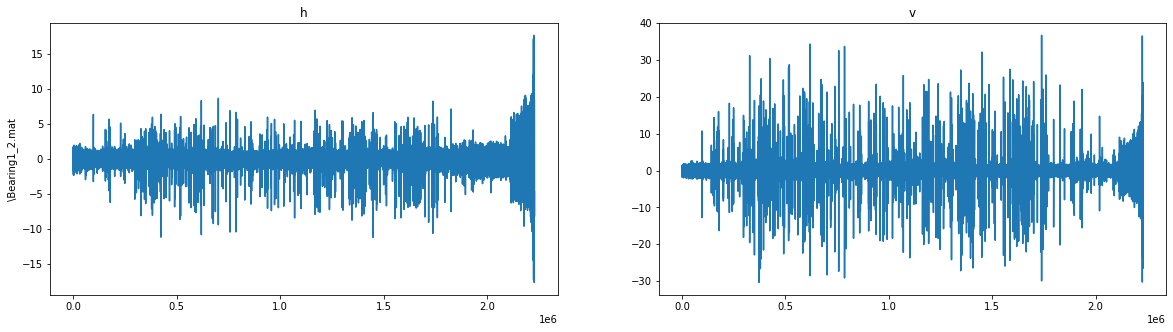

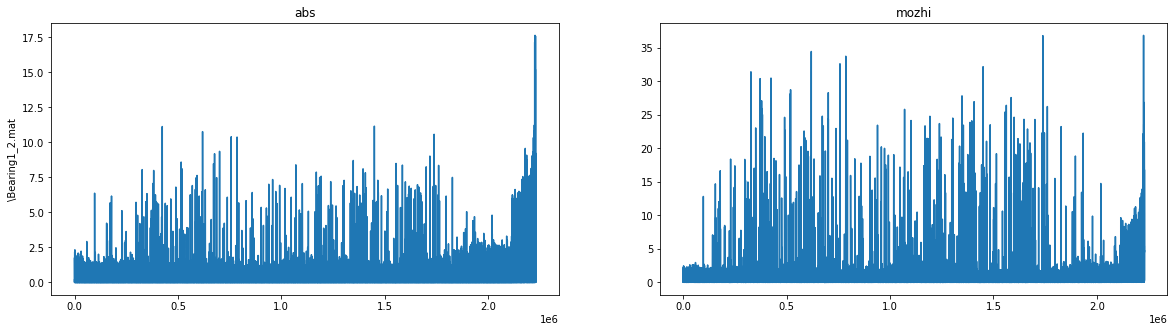

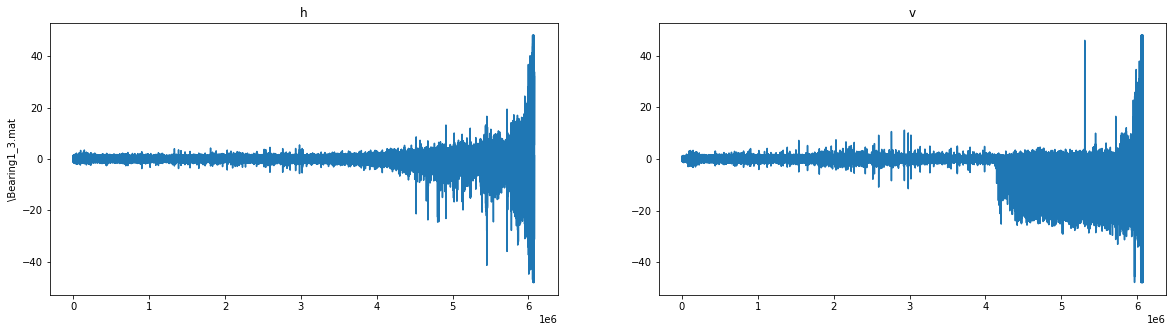

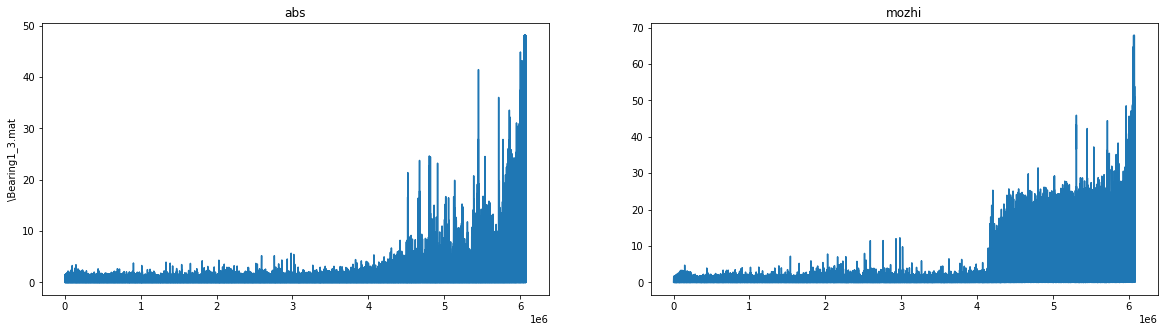

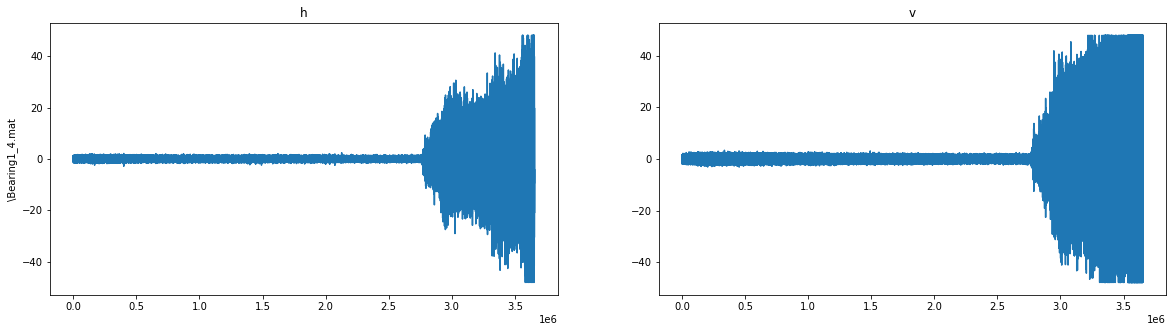

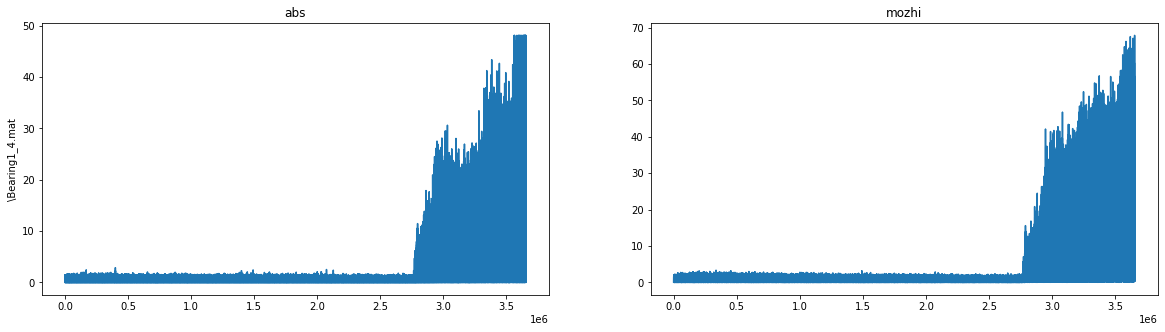

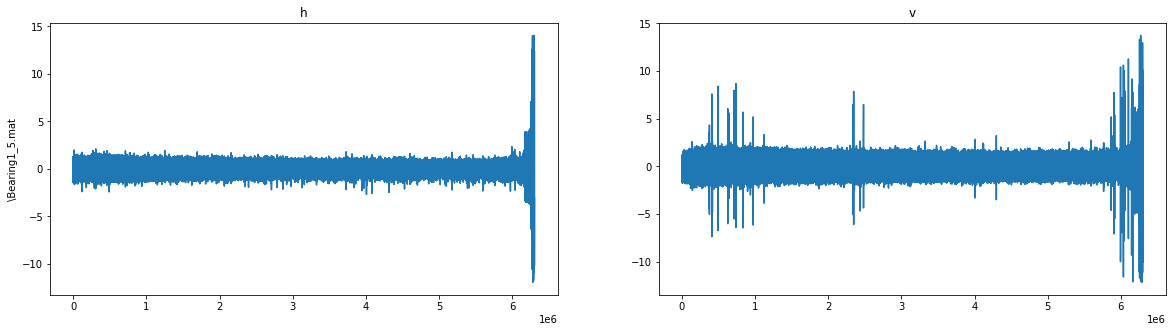

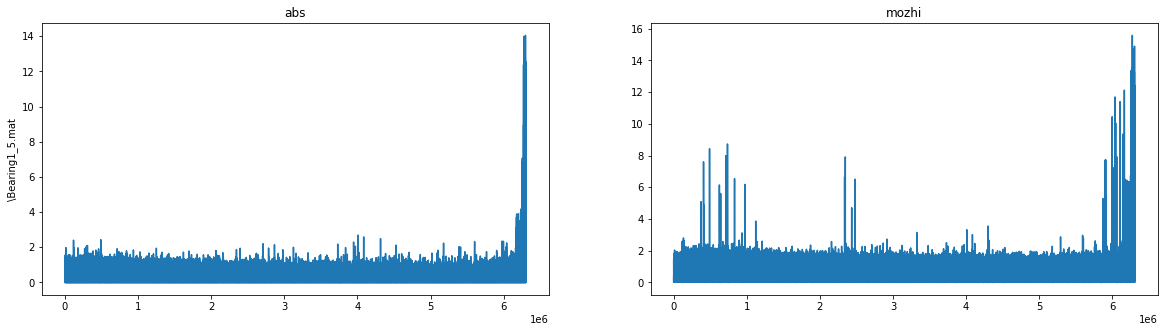

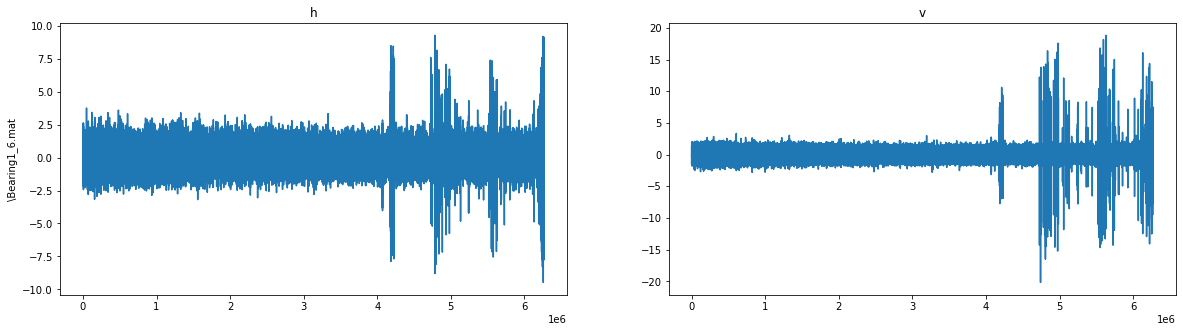

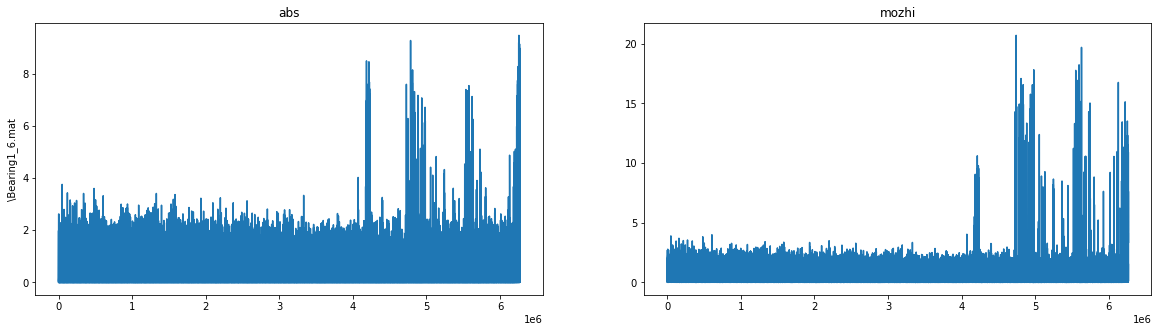

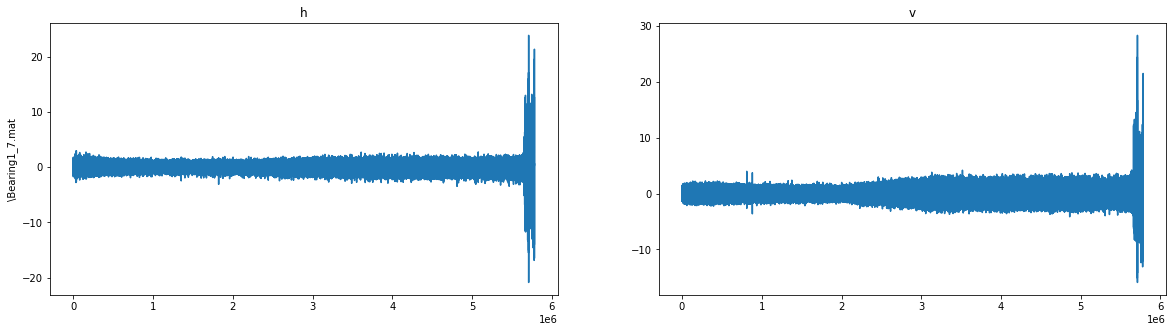

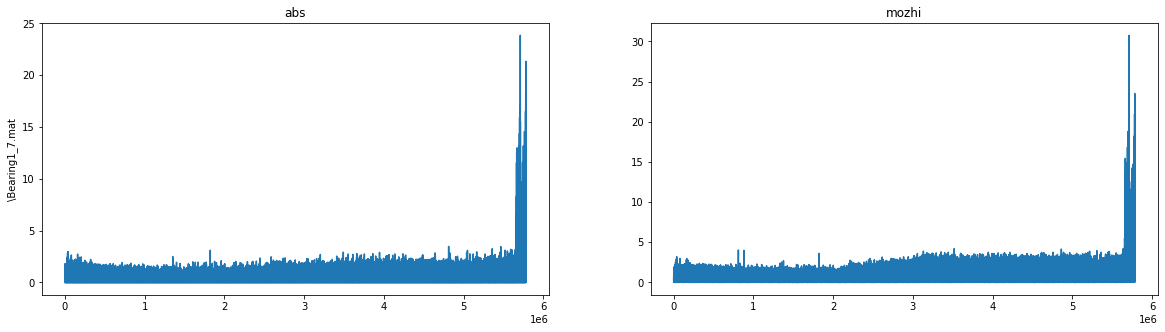

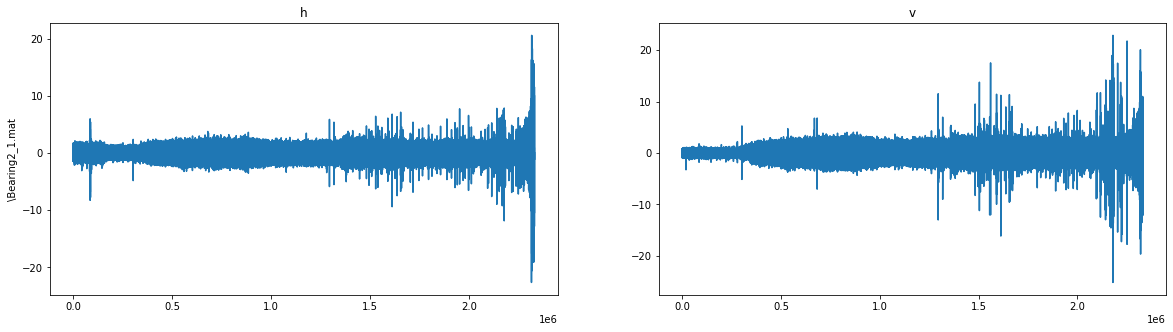

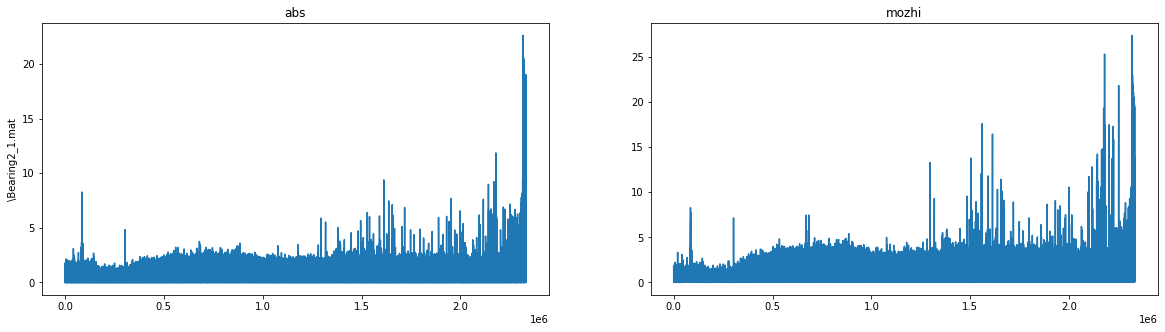

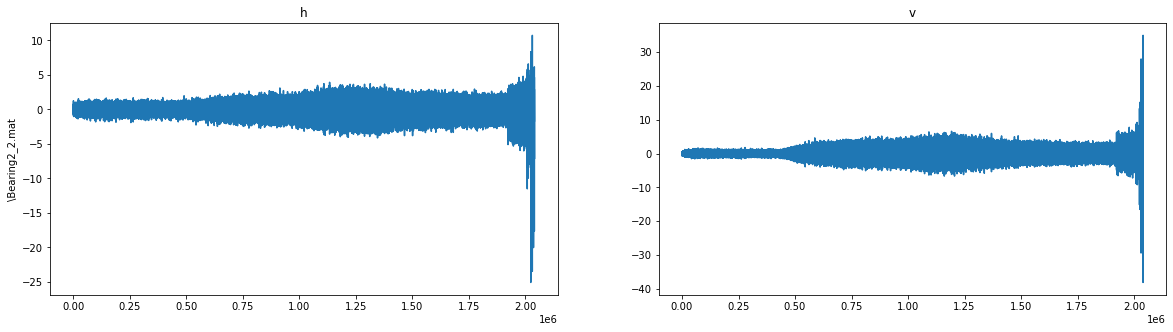

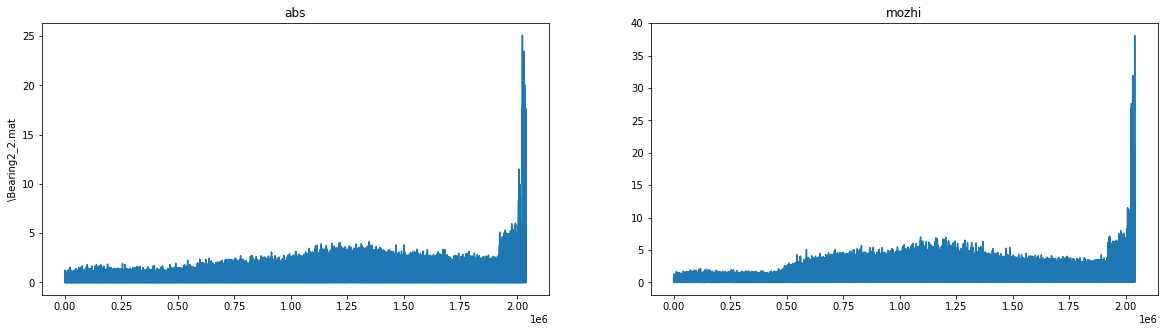

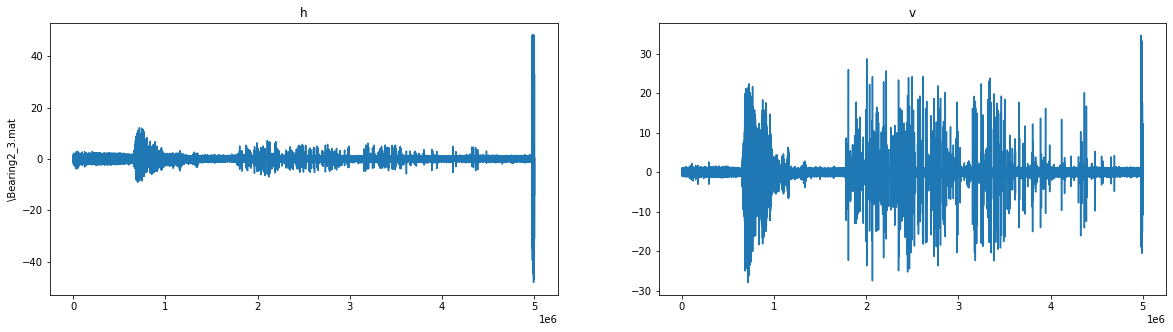

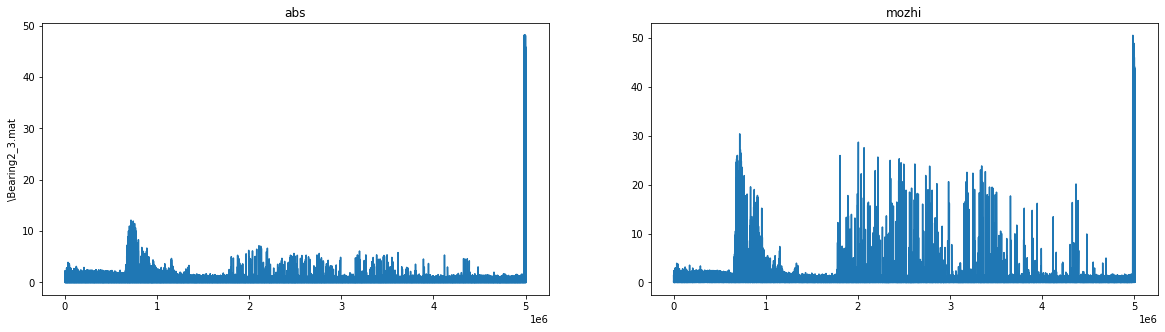

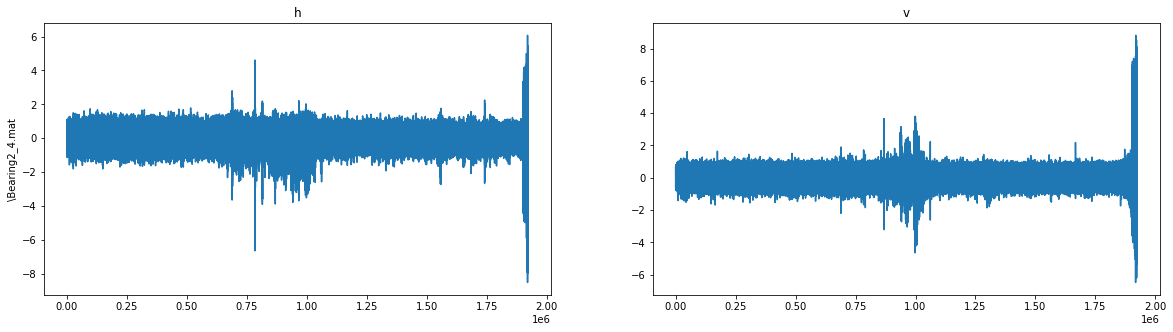

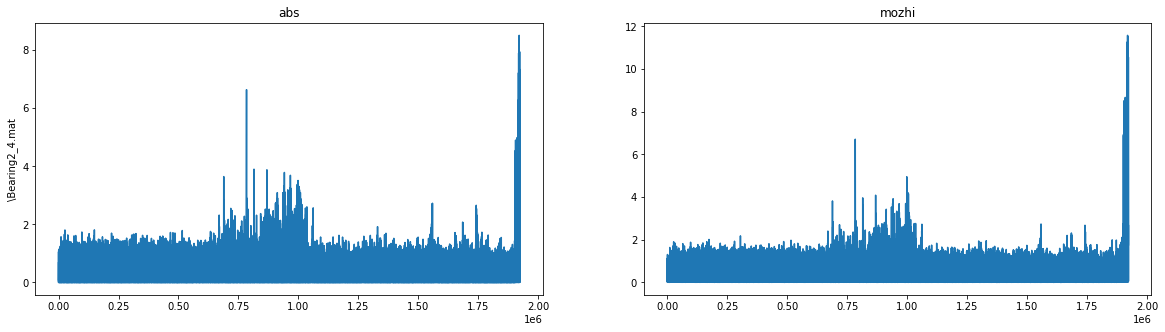

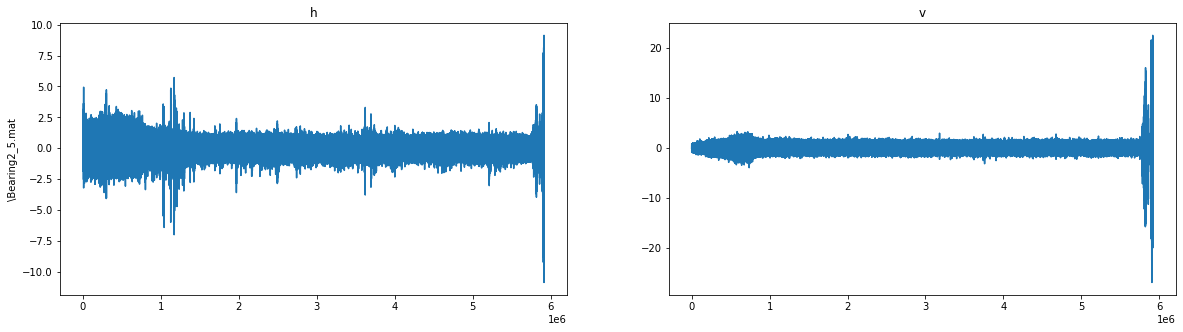

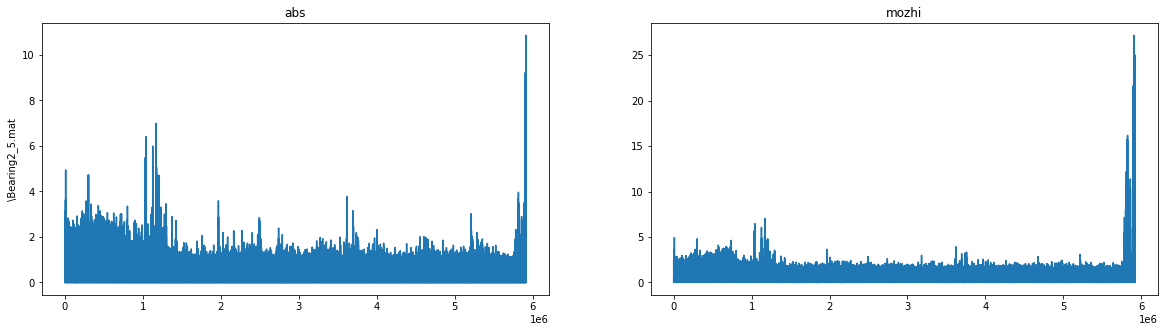

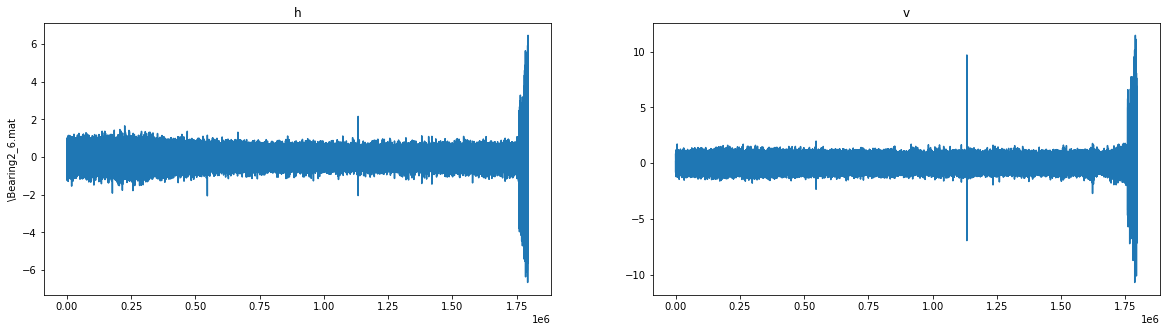

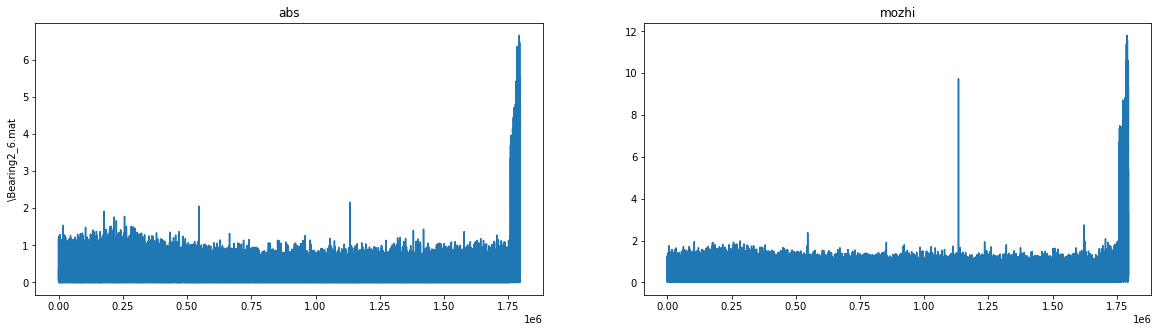

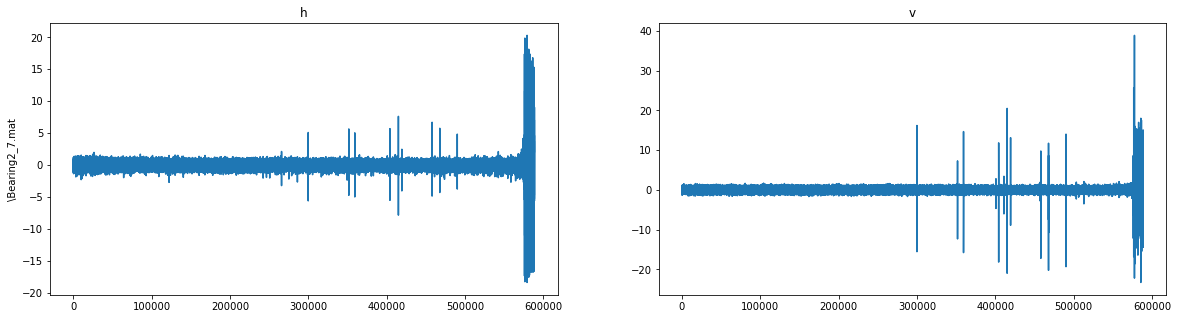

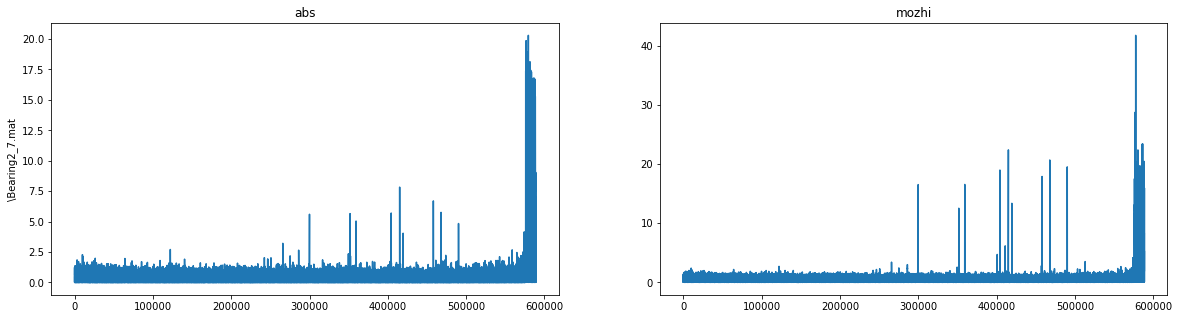

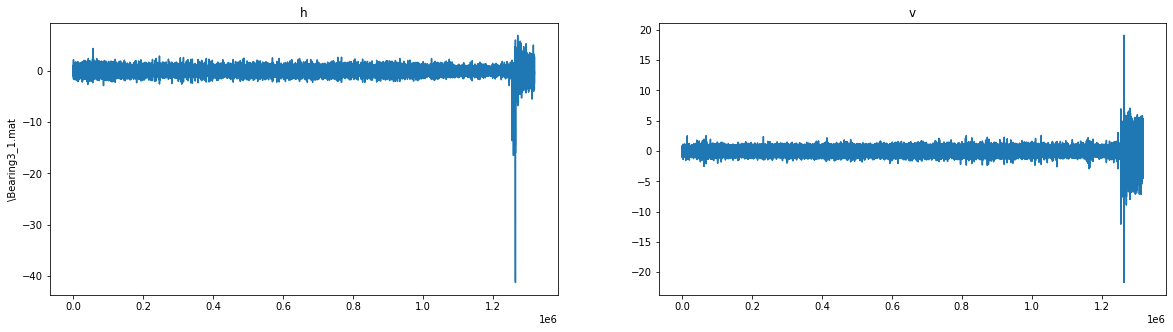

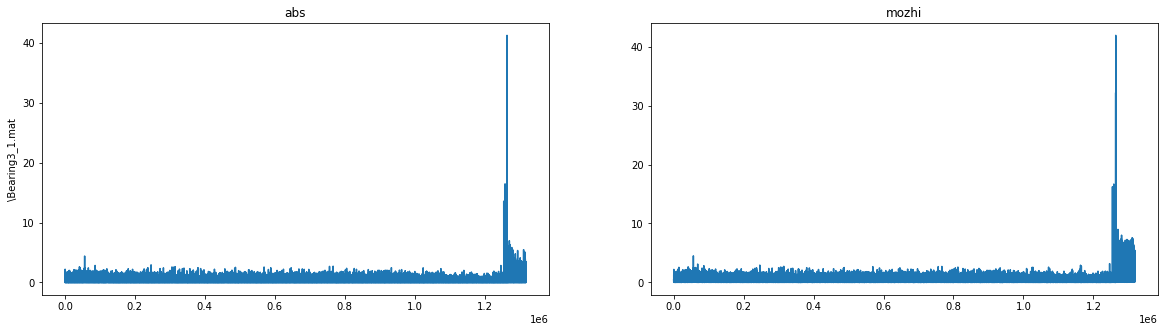

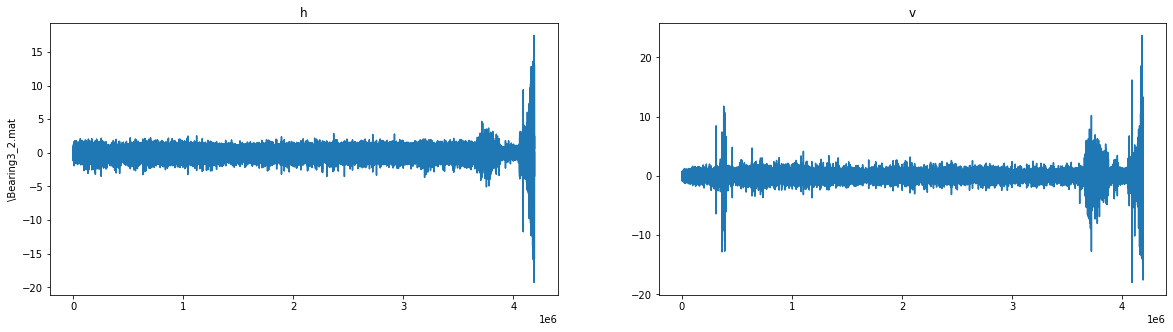

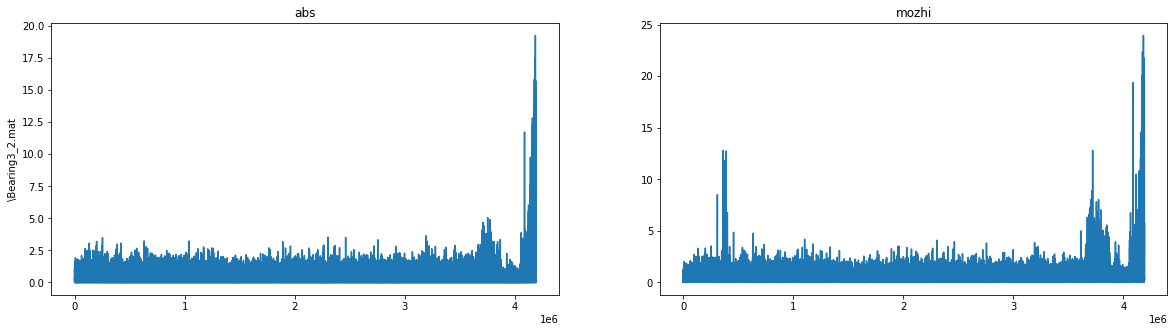

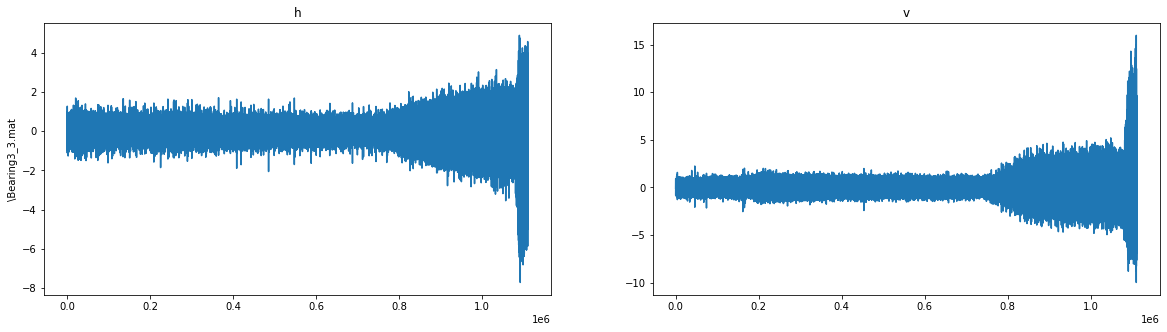

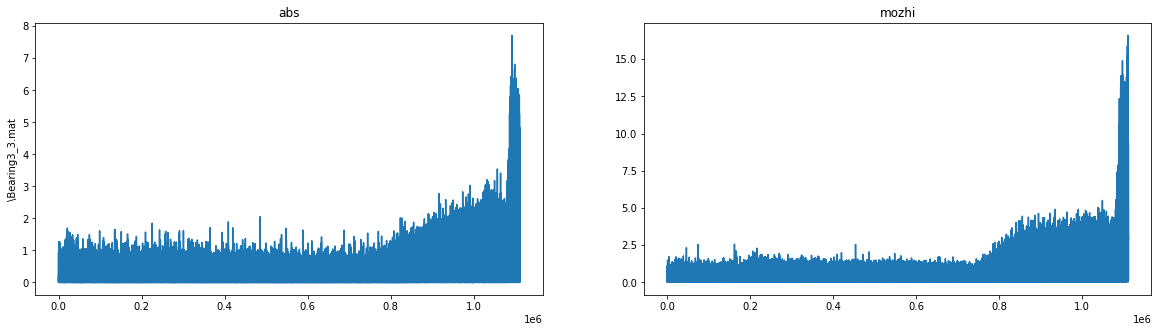

In [8]:
for f in bearing_files:
    h,v = load_mat(f)
    a = np.abs(np.array(h,dtype=np.complex) + np.array(v,dtype=np.complex)*(-1)**0.5)
    
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.plot(h)
    plt.ylabel(f[-15:])
    plt.title('h')

    plt.subplot(122)
    plt.plot(v)
    plt.title('v')
    plt.show()
    
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.plot(np.abs(h))
    plt.ylabel(f[-15:])
    plt.title('abs')

    plt.subplot(122)
    plt.plot(a)
    plt.title('mozhi')
    plt.show()